In [7]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import eofs
import xrft
#from cdo import Cdo
#cdo = Cdo(tempdir='network/aopp/chaos/pred/leach/.cdo_temp_files')
# uncomment the below if you want to/ clean up the temporary directory
# cdo.cleanTempDir()
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import regionmask
import xskillscore as xs
import pandas as pd
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
import palettable
from shapely.geometry.polygon import LinearRing
import copy
import shutil
import gzip
import warnings

#sys.path.append('/home/l/luol/Downloads/')
#import ScientificColourMaps6 as SCM6

from IPython.display import display, clear_output

## get FaIR
from fair import *

## get my stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

## matplotlib rcParams
## IF you want to use thesis style

import requests
from io import StringIO, BytesIO

req = requests.get('https://raw.githubusercontent.com/njleach/Thesis/main/ancil/figure-style.mplstyle')
'''
with open("/home/l/leach/thesis.mplstyle", "w") as text_file:
    text_file.write(req.content.decode())
    
plt.style.use("/home/l/leach/thesis.mplstyle")
textwidth = matplotlib.rcParams['figure.figsize'][0]

%matplotlib inline
'''

'\nwith open("/home/l/leach/thesis.mplstyle", "w") as text_file:\n    text_file.write(req.content.decode())\n    \nplt.style.use("/home/l/leach/thesis.mplstyle")\ntextwidth = matplotlib.rcParams[\'figure.figsize\'][0]\n\n%matplotlib inline\n'

In [8]:
import dask
from dask.distributed import Client, LocalCluster

def setUpCluster(
    n_workers: int, low_workers: int, high_workers: int, memory_limit: int
):
    dask.config.set({"temporary_directory": "/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/tmp/"})
    dask.config.set({"array.slicing.split_large_chunks": True})
    dask.config.set({"distributed.worker.memory.spill": 0.8})
    dask.config.set({"distributed.worker.use_file_locking": True})
    # DASK CLUSTER SET UP
    cluster = LocalCluster(
        n_workers=n_workers,
        dashboard_address="localhost:14286",
        memory_limit=f"{memory_limit} GiB",
        threads_per_worker=2,
    )
    cluster.adapt(minimum=low_workers, maximum=high_workers)

    print(f"dashboard : {cluster.dashboard_link}")
    client = Client(cluster)

    return cluster, client

In [9]:
## set up dask
cluster, client = setUpCluster(n_workers= 6, low_workers= 4, high_workers=10, memory_limit=6)

2023-08-10 10:43:39,708 - distributed.deploy.spec - WARNING - Cluster closed without starting up


RuntimeError: Cluster failed to start: [Errno 13] Permission denied: '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/tmp/dask-scratch-space'

In [10]:

def import_medr_tracks_TE(fpath):
    
    df = pd.read_csv(fpath,skipinitialspace=True)
    
    expdict = {'1':'ENS','b2nn':'pi','b2nq':'pi','b2ns':'pi','b2no':'incr','b2nr':'incr','b2nt':'incr'}
    
    fname = fpath.split('/')[-1]
    _,expid,inidate,mem = fname.split('_')
    
    df['expid'] = expid
    df['experiment'] = expdict[expid]
    df['inidate'] = pd.to_datetime(inidate)
    df['number'] = int(mem)
    
    return df


In [11]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(import_medr_tracks_TE, glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))

P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

## add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==4')

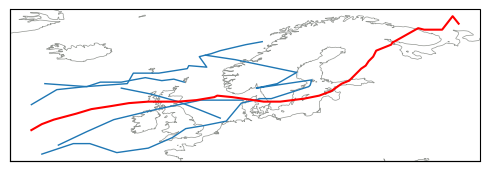

In [12]:


g=sn.relplot(data=ifs_tracks.query('inidate=="2022-02-10" & experiment=="ENS" & number==2'),x='lon',y='lat',size='track_id',sort=False,sizes=(1,1),kind='line',legend=False,facet_kws=dict(subplot_kws=dict(projection=crs.PlateCarree())))

sn.lineplot(data=eunice_track,x='lon',y='lat',legend=False,color='r')

g.axes[0,0].coastlines(color='xkcd:grey',lw=0.5)



In [13]:


ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min, day=np.size, lon = lambda x: x.iloc[0], lat = lambda x: x.iloc[0], msl = min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min, day=np.size, lon = lambda x: x.iloc[0], lat = lambda x: x.iloc[0], msl = min)).iloc[0]

eunice_filter



date    2022-02-15 06:00:00
day                      42
lon                   -27.0
lat                    52.0
msl                95954.33
Name: (4, 2022-01-01 00:00:00, era5, 0), dtype: object

In [14]:
## starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
## starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
## depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]


In [15]:
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

ifs_eunice_list.head()



,track_id,inidate,experiment,number,year,month,day,hour,i,j,lon,lat,msl,vo,expid,date
0,0,2022-02-14,ENS,16,2022,2,15,6,0,86,-27.00,52.00,99070.44,0.000121,1,2022-02-15 06:00:00
1,0,2022-02-14,ENS,16,2022,2,15,9,3,82,-26.25,53.00,98661.08,0.000183,1,2022-02-15 09:00:00
2,0,2022-02-14,ENS,16,2022,2,15,12,14,79,-23.50,53.75,98429.77,0.000234,1,2022-02-15 12:00:00
3,0,2022-02-14,ENS,16,2022,2,15,15,21,76,-21.75,54.50,98170.72,0.000234,1,2022-02-15 15:00:00
4,0,2022-02-14,ENS,16,2022,2,15,21,0,71,-27.00,55.75,97449.38,0.000102,1,2022-02-15 21:00:00


In [16]:
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

multi_track_members



,,,year
inidate,experiment,number,


In [17]:
def eunice_dist(df):
    
    eunice_lons = eunice_track.lon.values
    eunice_lats = eunice_track.lat.values
    
    track_lons = df.lon.values
    track_lats = df.lat.values
    
    minsize = min(eunice_lons.size,track_lons.size)
    
    return np.sqrt((track_lons[:minsize]-eunice_lons[:minsize])**2+(track_lats[:minsize]-eunice_lats[:minsize])**2).sum()


In [18]:
for idx in multi_track_members.index:
    
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(eunice_dist)
    
    num_reject = track_dists.idxmax()
    
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)



In [ ]:
g=sn.relplot(data=ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])],x='lon',y='lat',row='inidate',hue='experiment',hue_order=['pi','ENS','incr'],palette=get_palette.Petroff6().to_sn_palette(),size='number',sort=False,estimator=None,sizes=(0.66,0.66),kind='line',height=4.5,legend=False,facet_kws=dict(subplot_kws=dict(projection=crs.PlateCarree())),aspect=3)

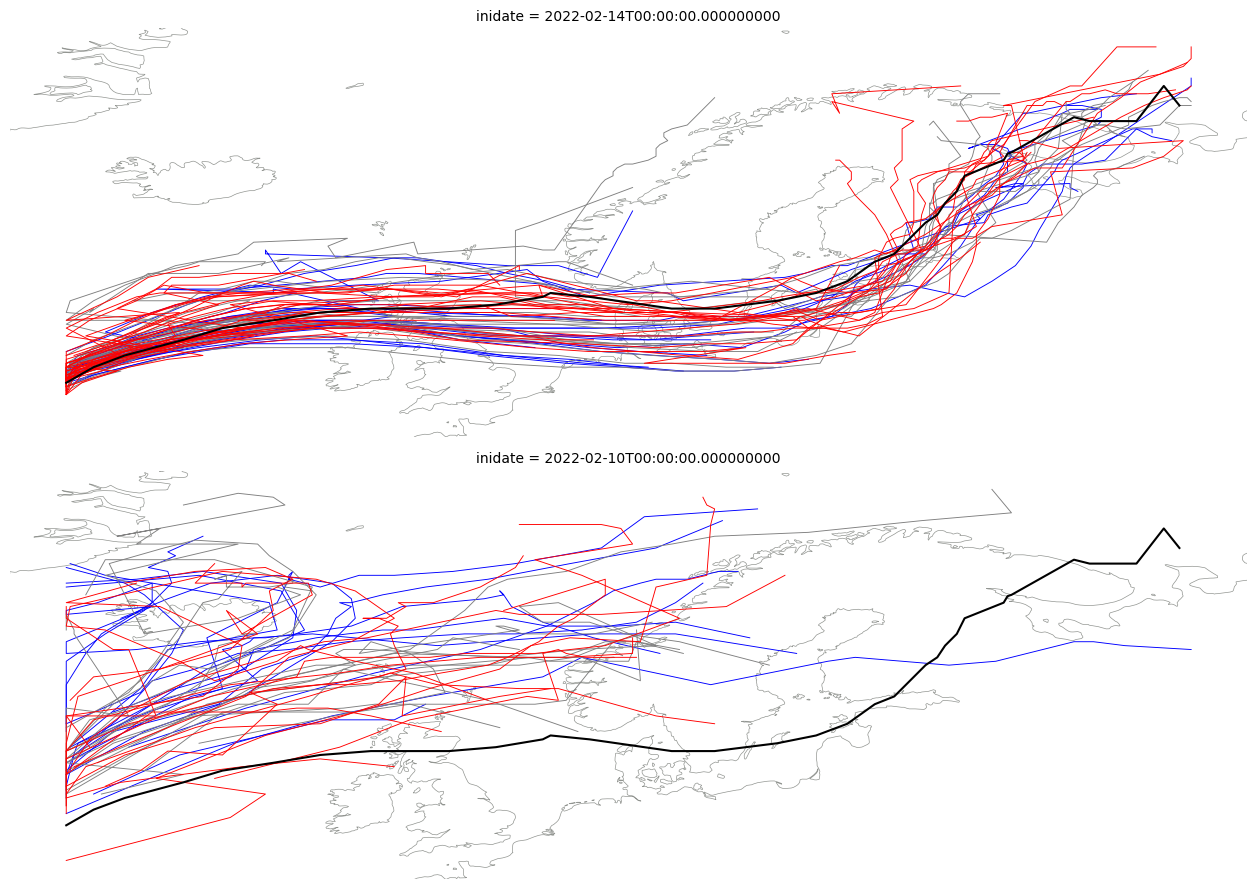

In [34]:
g=sn.relplot(data=ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])],x='lon',y='lat',row='inidate',hue='experiment',hue_order=['pi','ENS','incr'],palette=['b','grey','r'],size='number',sort=False,estimator=None,sizes=(0.66,0.66),kind='line',height=4.5,legend=False,facet_kws=dict(subplot_kws=dict(projection=crs.PlateCarree())),aspect=3)

[sn.lineplot(data=eunice_track,x='lon',y='lat',legend=False,color='k',ax=a) for a in g.axes.flatten()]
[a.coastlines(color='xkcd:grey',lw=0.5) for a in g.axes.flatten()]
[a.axis('off') for a in g.axes.flatten()];

In [23]:
import stormeunice as eun

In [24]:
'''def preproc_to_stormframe(ds):
    
    ds = ds.copy()
    
    if not 'number' in ds.coords:
        ds = ds.expand_dims({'number':[0]})
        
    fpath = ds.encoding['source']
    
    exp = fpath.split('/')[-5]
    inidate = fpath.split('/')[-1].split('_')[-1].split('.')[0]
    
    ds_tracks = ifs_eunice_list.query('experiment=="{}" & inidate=="{}"'.format(exp,inidate))

    LG_fields = []

    for num in set(ds.number.values).intersection(ds_tracks.number.unique()):

        mem_track = ds_tracks.loc[ds_tracks.number==num]
        mem_fields = ds.sel(number=num)
        time_intersection = sorted(list(set(mem_fields.time.values).intersection(mem_track.date.values)))
        
        resample_freq = 3 ## resampling frequency in hours
        if inidate == '2022-02-10':
            resample_freq = 6
        
        ## get start / end times for properly calculating the maximum fields (taking into account the different preproc times in IFS)
        time_start = time_intersection[0]-pd.Timedelta('{}h 59m'.format(resample_freq-1))
        time_end = time_intersection[-1]

        ## get the instantaneous fields + wind speeds
        mem_fields_out = mem_fields.get(['sst','u10','v10','msl','u100','v100','tcwv']).sel(time = time_intersection)
        mem_fields_out['ws10'] = np.sqrt(mem_fields_out.u10**2+mem_fields_out.v10**2)
        mem_fields_out['ws100'] = np.sqrt(mem_fields_out.u100**2+mem_fields_out.v100**2)
        
        ## get the maximum fields, taking into account the different preproc times
        mxtpr_field_out = mem_fields.mxtpr.sel(time=slice(time_start,time_end)).resample(time='{}h'.format(resample_freq),label='right',closed='right',base=0).max()
        mem_fields_out['mxtpr'] = mxtpr_field_out

        ## add in the mslp centroid lon/lats for Lagrangian analysis 
        mem_track_out = mem_track.loc[mem_track.date.isin(time_intersection)]
        mem_fields_out['centroid_lon'] = ('time',(mem_track_out.lon*4).round()/4)
        mem_fields_out['centroid_lat'] = ('time',(mem_track_out.lat*4).round()/4)

        ## convert to storm frame fields
        mem_fields_out = mem_fields_out.groupby('time').apply(eun.lagrangian.Lagrange.lagrangian_frame)
        mem_fields_out = mem_fields_out.assign(datetime=mem_fields_out.time).drop('time').rename(time='timestep')
        
        ## compute the time of peak vorticity (include moving average to smooth) for storm composites
        peak_vo = mem_track.rolling(3,center=True).mean().vo.idxmax()
        peak_vo_datetime = mem_track.date.loc[peak_vo]
        peak_vo_relative_time = (mem_fields_out.datetime.squeeze().to_pandas() - peak_vo_datetime).dt.total_seconds().values/(3600*24)

        ## set the storm frame fields timestep relative to peak vorticity time
        mem_fields_out = mem_fields_out.assign_coords(timestep=peak_vo_relative_time)

        LG_fields += [mem_fields_out]
        
    LG_fields = xr.concat(LG_fields,'number')
    
    LG_fields = LG_fields.expand_dims(dict(inidate=[pd.to_datetime(inidate)],experiment=[exp]))
    
    return LG_fields
    '''

In [25]:
'''ens_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)
'''

ValueError: must supply at least one object to concatenate

In [30]:
xr.open_dataarray('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc')

FileNotFoundError: [Errno 2] No such file or directory: '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc'

In [32]:
'''
# Import field data, Lagrangian fram
curr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc',
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
                                '''

AttributeError: 'NoneType' object has no attribute 'query'